In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

Переводим в тензор и нормализуем

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),  # превращаем изображение в тензор
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # нормализация по каналам RGB
])


Загрузка наборов данных

In [6]:
trainset = torchvision.datasets.CIFAR10(
    root='./data',  # где хранить данные
    train=True,     # загрузить обучающую часть
    download=True,  # если данных нет — скачать
    transform=transform  # применить трансформации
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


100.0%


Создаем DataLoader'ы

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


Проверяем одну партию изображений

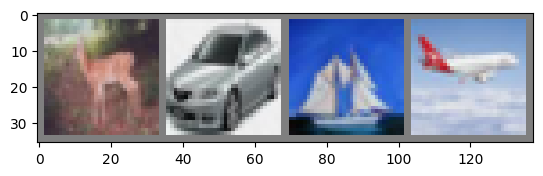

deer  automobile ship  airplane


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# функция для обратного преобразования (чтобы показать картинку)
def imshow(img):
    img = img / 2 + 0.5  # денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# получаем одну партию изображений
dataiter = iter(trainloader)
images, labels = next(dataiter)

# показываем изображения
imshow(torchvision.utils.make_grid(images))

# печатаем метки классов
print(' '.join(f'{trainset.classes[labels[j]]:5s}' for j in range(4)))


Прописываем архитектуру

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)      # 3 входных канала (RGB), 6 выходных, ядро 5x5
        self.pool = nn.MaxPool2d(2, 2)       # уменьшаем изображение в 2 раза
        self.conv2 = nn.Conv2d(6, 16, 5)     # вторая свертка
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # полносвязные слои
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)          # 10 классов

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # conv1 + ReLU + pooling
        x = self.pool(F.relu(self.conv2(x)))  # conv2 + ReLU + pooling
        x = torch.flatten(x, 1)               # разворачиваем в вектор
        x = F.relu(self.fc1(x))               # скрытые слои
        x = F.relu(self.fc2(x))
        x = self.fc3(x)                       # выход (10 значений — классы)
        return x

net = Net()


Прописываем функцию потерь и оптимизатор

In [11]:
criterion = nn.CrossEntropyLoss()  # типичная функция потерь для классификации
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


Обучаем модель

In [15]:
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()         # обнуляем градиенты
        outputs = net(inputs)         # прямой проход
        loss = criterion(outputs, labels)  # считаем ошибку
        loss.backward()               # обратное распространение
        optimizer.step()              # обновляем веса

        running_loss += loss.item()
        if i % 2000 == 1999:  # каждые 2000 мини-батчей
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

print("Обучение завершено!")


[1, 2000] loss: 1.271
[1, 4000] loss: 1.251
[1, 6000] loss: 1.256
[1, 8000] loss: 1.233
[1, 10000] loss: 1.229
[1, 12000] loss: 1.227
[2, 2000] loss: 1.147
[2, 4000] loss: 1.151
[2, 6000] loss: 1.176
[2, 8000] loss: 1.152
[2, 10000] loss: 1.162
[2, 12000] loss: 1.138
[3, 2000] loss: 1.069
[3, 4000] loss: 1.073
[3, 6000] loss: 1.099
[3, 8000] loss: 1.078
[3, 10000] loss: 1.093
[3, 12000] loss: 1.100
[4, 2000] loss: 1.014
[4, 4000] loss: 1.017
[4, 6000] loss: 1.023
[4, 8000] loss: 1.040
[4, 10000] loss: 1.047
[4, 12000] loss: 1.037
[5, 2000] loss: 0.956
[5, 4000] loss: 0.983
[5, 6000] loss: 0.971
[5, 8000] loss: 1.013
[5, 10000] loss: 1.001
[5, 12000] loss: 0.995
[6, 2000] loss: 0.907
[6, 4000] loss: 0.923
[6, 6000] loss: 0.928
[6, 8000] loss: 0.984
[6, 10000] loss: 0.977
[6, 12000] loss: 0.954
[7, 2000] loss: 0.891
[7, 4000] loss: 0.885
[7, 6000] loss: 0.897
[7, 8000] loss: 0.908
[7, 10000] loss: 0.948
[7, 12000] loss: 0.929
[8, 2000] loss: 0.840
[8, 4000] loss: 0.847
[8, 6000] loss: 0.

In [16]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
print("Модель сохранена в", PATH)


Модель сохранена в ./cifar_net.pth


Проверяем работу модели

In [17]:
correct = 0
total = 0
with torch.no_grad():  # отключаем подсчет градиентов
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Точность модели на 10000 тестовых изображениях: {100 * correct / total:.2f}%')


Точность модели на 10000 тестовых изображениях: 60.71%


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# функции для отображения изображений
def imshow(img):
    img = img / 2 + 0.5     # обратное преобразование нормализации
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


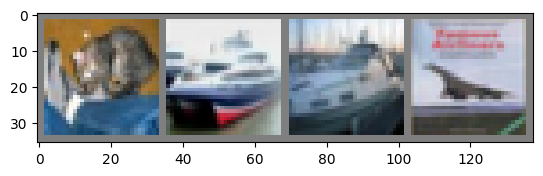

Настоящие метки: cat   ship  ship  plane


In [22]:
# получаем случайные изображения из тестового набора
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(testloader)
images, labels = next(dataiter)

# показываем изображения
imshow(torchvision.utils.make_grid(images))

# выводим настоящие классы
print('Настоящие метки:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [23]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Предсказания модели:', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))


Предсказания модели: cat   ship  ship  ship 
